# Train and eval models

## Load dataset

In [15]:
import matplotlib.pyplot as plt
import itertools
from collections import Counter

In [16]:
import pandas as pd

In [17]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [48]:
dataset_id = "ag_news"
dataset = load_dataset(dataset_id)
dataset

Using custom data configuration default
Reusing dataset ag_news (/Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [19]:
label_class = dataset["train"].features["label"]
label_names = label_class.names
label_names

['World', 'Sports', 'Business', 'Sci/Tech']

## Quick check to verify the dataset is not corrupted

In [44]:
dataset.set_format(type="pandas")

In [32]:
train_df = dataset["train"][:]
train_df["label_name"] = train_df["label"].apply(label_class.int2str)

In [33]:
test_df = dataset["test"][:]
test_df["label_name"] = test_df["label"].apply(label_class.int2str)

In [34]:
train_df.sample(5)

,text,label,label_name
97117,"India Pulls Out About 3,000 Troops from Kashmi...",0,World
39184,Iraqi PM asks UN for rebuilding help UNITED NA...,0,World
103169,"O Christmas tree In the past five years, natio...",2,Business
37758,African union seeks up to 5000 troops for Darf...,0,World
95530,Robinson Signs Deal to Manage Expos in DC (Reu...,1,Sports


In [35]:
test_df.sample(5)

,text,label,label_name
2095,Porn Processor Settles Deceptive-Billing Charg...,3,Sci/Tech
4030,IBM posts broad Q3 revenue growth NEW YORK - I...,3,Sci/Tech
1477,"Grenada In Crisis - Friday 10, September-2004 ...",0,World
5985,PM backs indigenous alcohol ban CURFEWS and al...,0,World
7293,Yahoo! Hires Chief Data Officer In a move that...,3,Sci/Tech


In [55]:
train_df["label_name"].value_counts()

Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: label_name, dtype: int64

In [56]:
test_df["label_name"].value_counts()

Business    1900
Sci/Tech    1900
Sports      1900
World       1900
Name: label_name, dtype: int64

In [46]:
dataset.reset_format()

## Tokenize dataset

In [51]:
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [79]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [80]:
tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-f001d13101675a0f.arrow


In [81]:
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [82]:
tokenized_dataset["train"][0]

{'label': tensor(2),
 'input_ids': tensor([  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
          1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
          2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
          1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [83]:
tokenized_dataset["test"][0]

{'label': tensor(2),
 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
          3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
          1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

## Define metrics functions

In [106]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [101]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(len(labels),len(labels)))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
    print(cm)
    return cm

In [88]:
y_true = [1]*50 + [0]*50
y_pred = [1]*40 + [0]*60

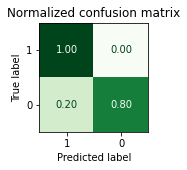

[[1.  0. ]
 [0.2 0.8]]


In [102]:
cm = plot_confusion_matrix(y_true, y_pred, labels=["1", "0"])

In [109]:
precision_recall_fscore_support(y_true, y_pred)

(array([0.83333333, 1.        ]),
 array([1. , 0.8]),
 array([0.90909091, 0.88888889]),
 array([50, 50]))

In [110]:
def display_prfs(y_true, y_pred, labels):
    fig, ax = plt.subplots(figsize=(len(labels), ))
    
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [103]:
# For training loop
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    return f1_score(labels, preds, average="weighted")